In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns  # make plots prettier
import os
import matplotlib.gridspec as gridspec
import glob
from scipy.ndimage import gaussian_filter
import colorcet as cc

In [27]:
def set_plotting_style():
    """
    Formats plotting enviroment to that used in Physical Biology of the Cell,
    2nd edition. To format all plots within a script, simply execute
    `mwc_induction_utils.set_plotting_style() in the preamble.
    """
    rc = {'lines.linewidth': 2,
          'axes.labelsize': 10,
          'axes.titlesize': 9,
          'axes.facecolor': '#E3DCD0',
          'xtick.labelsize': 7,
          'ytick.labelsize': 7,
          # 'font.family': 'Lucida Sans Unicode',
          'grid.linestyle': '-',
          'grid.linewidth': 0.5,
          'grid.color': '#ffffff',
          'legend.fontsize': 12}
    plt.rc('text.latex', preamble=r'\usepackage{sfmath}')
    plt.rc('xtick.major', pad=-1)
    plt.rc('ytick.major', pad=-1)
    plt.rc('mathtext', fontset='stixsans', sf='sansserif')
    plt.rc('figure', figsize=[4.0, 3.0])
    plt.rc('svg', fonttype='none')
    plt.rc('legend', title_fontsize='16', frameon=True, 
           facecolor='#E3DCD0', framealpha=1)
    sns.set_style('darkgrid', rc=rc)
    sns.set_palette("colorblind", color_codes=True)
    sns.set_context('notebook', rc=rc)

set_plotting_style()


In [28]:
def plot_dataframes(dataframes, labels, filename=None, max_frame=None):
    """
    Plots the data in a 2x2 grid of subplots.
    
    Parameters:
    - dataframes: List of pandas DataFrames, each containing the data to be plotted.
    - labels: List of strings, each being the label corresponding to a DataFrame in `dataframes`.
    - filename: Optional; String, the filename (including path) to save the plot. If None, the plot will be displayed.
    """
    
    if len(dataframes) != len(labels):
        raise ValueError("Number of dataframes must be equal to number of labels")
    
    # Define the titles for each subplot in µm and µm/s
    titles = [['Velocity (µm/s)', 'Distance (µm)'], ['Power (W)', 'Work (J)']]
    
    # Create figure
    fig = plt.figure(figsize=(16, 9))
    
    # Define the GridSpec
    gs = gridspec.GridSpec(2, 2, width_ratios=[2, 1])  # 2:1 width ratio
    
    # Create subplots
    axs = [[plt.subplot(gs[i, j]) for j in range(2)] for i in range(2)]
    
    # Loop over each dataframe and label, and plot each variable in a separate subplot
    for df, label in zip(dataframes, labels):

        df = df.iloc[:max_frame,:]
        
        line, = axs[0][0].plot(df['time_min'], df['v (m/s)'] * 1e6, label=label)  # Convert to µm/s for plotting
        axs[0][0].fill_between(df['time_min'], df['v (m/s)'] * 1e6, color=line.get_color(), alpha=0.2)
        
        axs[0][1].plot(df['time_min'].iloc[-1], df['distance (m)'].iloc[-1] * 1e6, 'o', label=label, markersize=8, color=line.get_color())
        
        line, = axs[1][0].plot(df['time_min'], df['Power (W)'], label=label)
        axs[1][0].fill_between(df['time_min'], df['Power (W)'], color=line.get_color(), alpha=0.2)
        
        axs[1][1].plot(df['time_min'].iloc[-1], df['Work (J)'].iloc[-1], 'o', label=label, markersize=8, color=line.get_color())
    
    # Set titles, labels, and legends
    for i in range(2):
        for j in range(2):
            # axs[i][j].set_title(titles[i][j])
            axs[i][j].set_xlabel('time (min)')
            axs[i][j].set_ylabel(titles[i][j])
            axs[i][j].legend()

    # Set axis limits
    axs[0][0].set_xlim(-0.5, df['time_min'].max() + 1)
    axs[0][0].set_ylim(-0.05, 1)
    
    axs[0][1].set_xlim(0, 100)
    axs[0][1].set_ylim(0, 300)
    
    axs[1][0].set_xlim(0, 105)
    axs[1][0].set_ylim(-0.25E-15, 5E-15)
    
    axs[1][1].set_xlim(0, 105)
    axs[1][1].set_ylim(0, 1E-13)        

    # Adjust layout
    plt.tight_layout()
    
    # Save or show the plot
    if filename:
        plt.savefig(filename, format='jpg', dpi=150)  # Save as PDF with high dpi
    else:
        plt.show()
    
    # Close the figure
    plt.close(fig)


In [29]:
def process_piv_data(link, µl, vmax=True, time_int=3, L=100, sigma=5, skip_frames=0, remove_end_frames=0):
    """
    Processes PIV data from a series of text files and calculates various physical quantities.
    
    Parameters:
    link (str): The path to the text files containing the data.
    µl (float): The volume in microliters used in calculations.
    vmax (bool): Whether to use the average of the top 10 velocities or the mean velocity.
    time_int (int): The time interval between measurements, used to calculate time in minutes.
    L (int): The correlation length, used in calculations.
    sigma (float): The standard deviation of the Gaussian kernel, used in the Gaussian filter.
    skip_frames (int): The number of initial frames to skip.
    remove_end_frames (int): The number of final frames to remove.
    
    Returns:
    pd.DataFrame: A DataFrame containing time, velocities, vorticities, divergences, distance, 
                  power, work, drag force, and cumulative drag force.
    """
    
    # Get sorted list of text files, skip the initial frames and remove the end frames as specified
    files = sorted(glob.glob(link))[skip_frames:-remove_end_frames or None]
    
    # Initialize lists to store extracted magnitudes
    velocities, vorticities, divergences = [], [], []
       
    for file in files:
        df = pd.read_csv(file, skiprows=2).fillna(0)
        
        # Determine method to calculate velocity
        if vmax:
            v = df['magnitude [m/s]'].nlargest(50).mean()
        else:
            v = df['magnitude [m/s]'].mean()
        
        velocities.append(v)
        vorticities.append(df["vorticity [1/s]"].mean())
        divergences.append(df["divergence [1/s]"].mean())

    
    # Create a DataFrame with time and processed velocities
    result_df = pd.DataFrame(velocities, columns=["v (m/s)"]).reset_index()
    result_df['time_min'] = result_df['index'] * time_int / 60
    result_df['v (m/s)'] = gaussian_filter(result_df['v (m/s)'] - result_df['v (m/s)'].min(), sigma=sigma)
    
    # Calculate additional physical quantities
    result_df['vorticity (1/s)'], result_df['divergence (1/s)'] = vorticities, divergences
    result_df['distance (m)'] = (result_df['v (m/s)'] * result_df['time_min'].diff()).cumsum()
    
    vol, µ, corr = µl * 1E-9, 1E-3, L * 1E-6  # Convert units for volume, viscosity, and correlation length
    result_df["Power (W)"] = vol * µ * (result_df["v (m/s)"] / corr) ** 2
    result_df['Work (J)'] = (result_df["Power (W)"] * result_df['time_min'].diff()).cumsum()
    
    r = 10e-6  # Radius of the bead in meters
    result_df['F_drag (N)'] = 6 * np.pi * µ * r * result_df['v (m/s)']
    result_df['F'] = (result_df["F_drag (N)"] * result_df['time_min'].diff()).cumsum()
    
    return result_df.iloc[:, 1:]

In [30]:
## Uncomment this to convert PIV data (txt file per frame) to a single dataframe

# link = "../../data/K401bio_protein-PIV_velocity_control/txt-500nM/PIVlab_****.txt"

# df = process_piv_data(link, µl=2)
# df.to_csv('../../data/K401bio_protein-PIV_velocity_control/K401bio_protein-PIV_velocity_control-vmax.csv')

In [31]:
link = "../../data/piv/K401bio_protein-PIV_velocity_control/K401bio_protein-PIV_velocity_control-vmax.csv"

df = pd.read_csv(link).iloc[:,1:]

In [32]:
# for i in range(1, len(df) + 1):  # Start from 1 to avoid empty DataFrame
#     plot_dataframes(
#         [df.iloc[:i,:]], 
#         ['500µM K401biotin + streptavidin'], 
#         filename=f"../../data/K401bio_protein-PIV_velocity_control/plots/plot{i}.jpg"
#     )


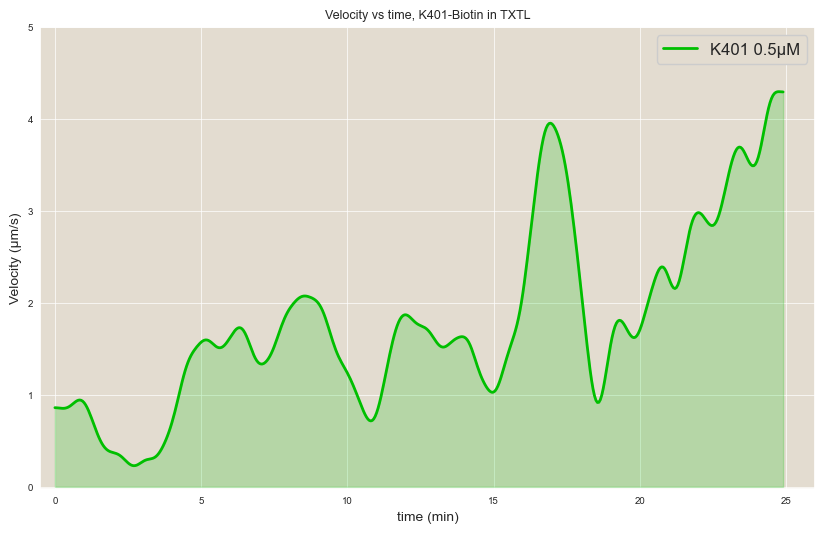

In [36]:
def plot_velocity(df, label, filename=None, max_frame=None, x_limits=None, y_limits=None):
    fig, ax = plt.subplots(figsize=(10, 6))
    
    df = df.iloc[:max_frame,:]
    
    # Use a green color from colorcet
    green_color = cc.glasbey_hv[27]  # Selecting a green color from the glasbey_hv colormap
    
    ax.plot(df['time_min'], df['v (m/s)'] * 1e6, label=label, color=green_color)
    ax.fill_between(df['time_min'], df['v (m/s)'] * 1e6, color=green_color, alpha=0.2)
    
    ax.set_xlabel('time (min)')
    ax.set_ylabel('Velocity (µm/s)')
    ax.set_title('Velocity vs time, K401-Biotin in TXTL')
    ax.legend()
    
    # Set axis limits if provided
    if x_limits:
        ax.set_xlim(x_limits)
    if y_limits:
        ax.set_ylim(y_limits)
    
    if filename:
        plt.savefig(filename, format='jpg', dpi=150)
    else:
        plt.show()
    
    plt.close(fig)

plot_velocity(df, 'K401 0.5µM', x_limits=(-0.5,26), y_limits=(-0.025,5))

In [41]:
# Uncomment to generate image sequence of plots per frame

# Define directory name
dir_name = "../../data/piv/K401bio_protein-PIV_velocity_control/plots/plots_velocity/"

# Check if directory exists, if not, create it
if not os.path.exists(dir_name):
    os.makedirs(dir_name)
    
    
for i in range(1, len(df) + 1):
    plot_velocity(
        df.iloc[:i,:], 
        'K401 0.5µM', 
        x_limits=(-0.5,26), y_limits=(-0.025,5), 
        filename=f"{dir_name}/velocity_plot_{i}.jpg")

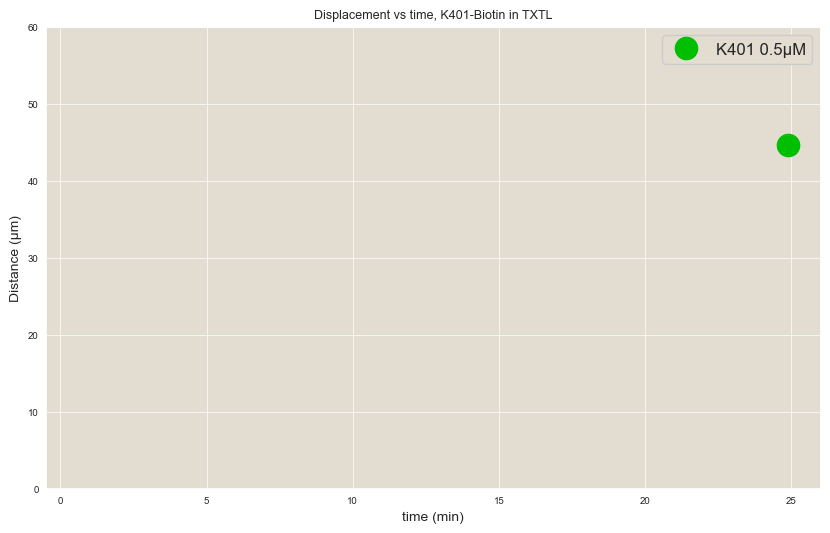

In [70]:
def plot_distance(df, label, filename=None, max_frame=None, x_limits=None, y_limits=None):
    fig, ax = plt.subplots(figsize=(10, 6))
    
    df = df.iloc[:max_frame,:]
    green_color = cc.glasbey_hv[27]  # Selecting a green color from the glasbey_hv colormap

    ax.plot(df['time_min'].iloc[-1], df['distance (m)'].iloc[-1] * 1e6, 'o', label=label, markersize=16, color=green_color)
    
    ax.set_xlabel('time (min)')
    ax.set_ylabel('Distance (µm)')
    ax.set_title('Displacement vs time, K401-Biotin in TXTL')

    ax.legend()
    
    if x_limits:
        ax.set_xlim(x_limits)
    if y_limits:
        ax.set_ylim(y_limits)
    
    if filename:
        plt.savefig(filename, format='jpg', dpi=150)
    else:
        plt.show()
    
    plt.close(fig)

plot_distance(df, 'K401 0.5µM', x_limits=(-0.5,26), y_limits=(-0.025,60))

In [71]:
# Uncomment to generate image sequence of plots per frame

# Define directory name
dir_name = "../../data/piv/K401bio_protein-PIV_velocity_control/plots/plots_distance"

# Check if directory exists, if not, create it
if not os.path.exists(dir_name):
    os.makedirs(dir_name)
    
    
for i in range(1, len(df) + 1):
    plot_distance(
        df.iloc[:i,:], 
        'K401 0.5µM', 
        x_limits=(-0.5,26), y_limits=(-0.025,60),
        filename=f"{dir_name}/distance_plot_{i}.jpg"

    )

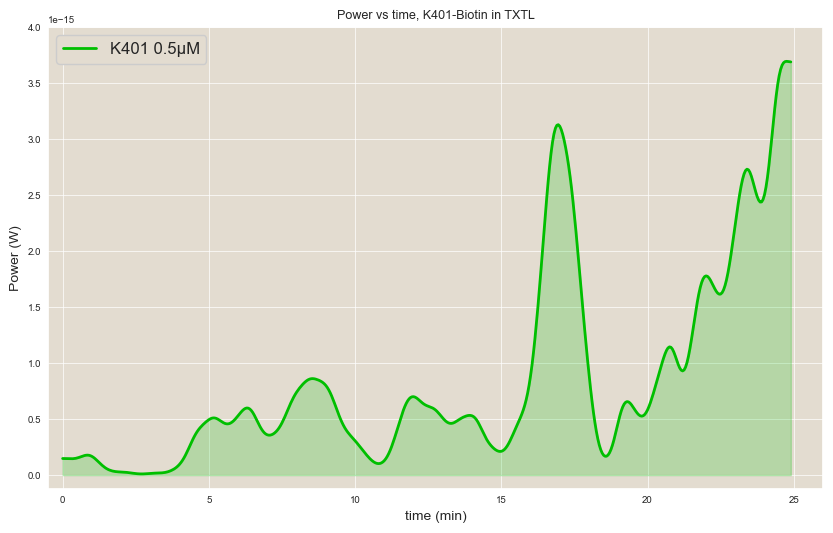

In [64]:
def plot_power(df, label, filename=None, max_frame=None, x_limits=None, y_limits=None):
    fig, ax = plt.subplots(figsize=(10, 6))
    
    df = df.iloc[:max_frame,:]
    green_color = cc.glasbey_hv[27]  # Selecting a green color from the glasbey_hv colormap

    
    ax.plot(df['time_min'], df['Power (W)'], label=label, color=green_color)
    ax.fill_between(df['time_min'], df['Power (W)'], alpha=0.2, color=green_color)
    
    ax.set_xlabel('time (min)')
    ax.set_ylabel('Power (W)')
    ax.set_title('Power vs time, K401-Biotin in TXTL')

    ax.legend()
    
    if x_limits:
        ax.set_xlim(x_limits)
    if y_limits:
        ax.set_ylim(y_limits)
    
    if filename:
        plt.savefig(filename, format='jpg', dpi=150)
    else:
        plt.show()
    
    plt.close(fig)

plot_power(df, 'K401 0.5µM', x_limits=(-0.5,26), y_limits=(-0.125E-15,4E-15))

In [65]:
# Uncomment to generate image sequence of plots per frame
# Define directory name
dir_name = "../../data/piv/K401bio_protein-PIV_velocity_control/plots/plots_power"

# Check if directory exists, if not, create it
if not os.path.exists(dir_name):
    os.makedirs(dir_name)
    
# Loop through each frame of df and save a plot
for i in range(1, len(df) + 1):
    plot_power(
        df.iloc[:i,:], 
        'K401 0.5µM',  
        x_limits=(-0.5,26), y_limits=(-0.125E-15,4E-15),
        filename=f"{dir_name}/power_plot_{i}.jpg"
    )

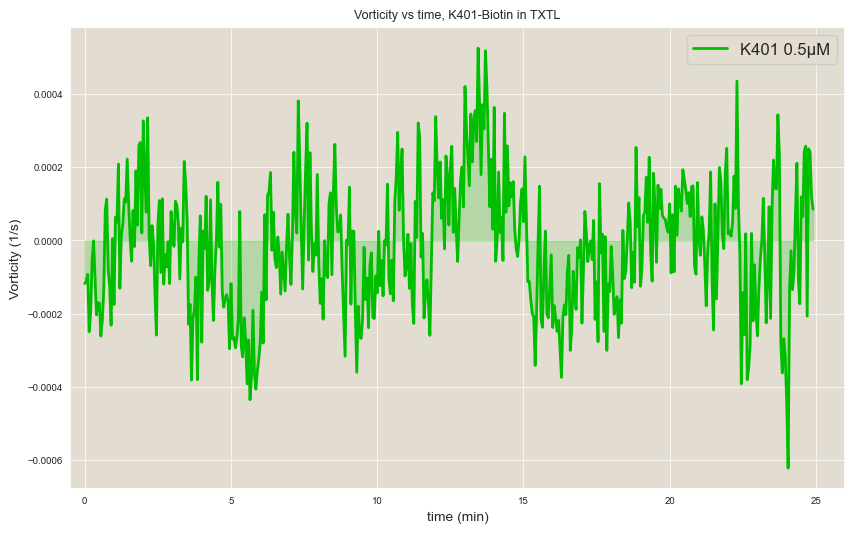

In [66]:
def plot_vorticity(df, label, filename=None, max_frame=None, x_limits=None, y_limits=None):
    fig, ax = plt.subplots(figsize=(10, 6))
    
    df = df.iloc[:max_frame,:]
    green_color = cc.glasbey_hv[27]  
    
    ax.plot(df['time_min'], df['vorticity (1/s)'], label=label, color=green_color)
    ax.fill_between(df['time_min'], df['vorticity (1/s)'], alpha=0.2, color=green_color)
    
    ax.set_xlabel('time (min)')
    ax.set_ylabel('Vorticity (1/s)')
    ax.set_title('Vorticity vs time, K401-Biotin in TXTL')
    ax.legend()
    
    if x_limits:
        ax.set_xlim(x_limits)
    if y_limits:
        ax.set_ylim(y_limits)
    
    if filename:
        plt.savefig(filename, format='jpg', dpi=150)
    else:
        plt.show()
    
    plt.close(fig)
    
plot_vorticity(df, 'K401 0.5µM', x_limits=(-0.5,26), y_limits=[None, None])

In [67]:
## Uncomment to generate image sequence of plots per frame
# Define directory name for vorticity
dir_name_vorticity = "../../data/piv/K401bio_protein-PIV_velocity_control/plots/plots_vorticity"

# Check if directory exists, if not, create it
if not os.path.exists(dir_name_vorticity):
    os.makedirs(dir_name_vorticity)
    
# Loop through each frame of df and save a plot for vorticity
for i in range(1, len(df) + 1):
    plot_vorticity(
        df.iloc[:i,:], 
        'K401 0.5µM', 
        x_limits=(-0.5,26), 
        y_limits=(-0.0007, 0.0007),  # Example y-limits, adjust accordingly
        filename=f"{dir_name_vorticity}/vorticity_plot_{i}.jpg"
    )


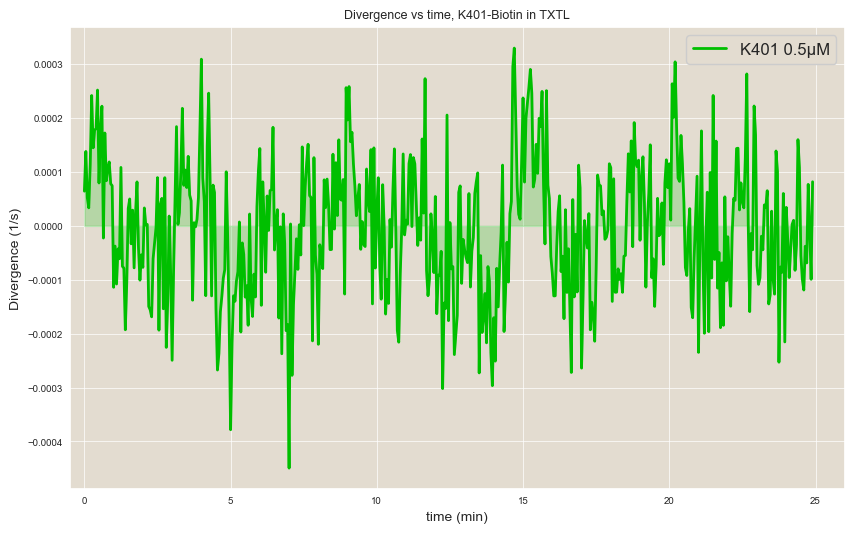

In [68]:
def plot_divergence(df, label, filename=None, max_frame=None, x_limits=None, y_limits=None):
    fig, ax = plt.subplots(figsize=(10, 6))
    
    df = df.iloc[:max_frame,:]
    green_color = cc.glasbey_hv[27]  
    
    ax.plot(df['time_min'], df['divergence (1/s)'], label=label, color=green_color)
    ax.fill_between(df['time_min'], df['divergence (1/s)'], alpha=0.2, color=green_color)
    
    ax.set_xlabel('time (min)')
    ax.set_ylabel('Divergence (1/s)')
    ax.set_title('Divergence vs time, K401-Biotin in TXTL')
    ax.legend()
    
    if x_limits:
        ax.set_xlim(x_limits)
    if y_limits:
        ax.set_ylim(y_limits)
    
    if filename:
        plt.savefig(filename, format='jpg', dpi=150)
    else:
        plt.show()
    
    plt.close(fig)
    
plot_divergence(df, 'K401 0.5µM', x_limits=(-0.5,26), y_limits=[None, None])

In [23]:
## Uncomment to generate image sequence of plots per frame
# Define directory name for divergence
dir_name_divergence = "../../data/K401bio_protein-PIV_velocity_control/plots/plots_divergence"

# Check if directory exists, if not, create it
if not os.path.exists(dir_name_divergence):
    os.makedirs(dir_name_divergence)
    
# Loop through each frame of df and save a plot for divergence
for i in range(1, len(df) + 1):
    plot_divergence(
        df.iloc[:i,:], 
        'K401 0.5µM', 
        x_limits=(-0.5,26), 
        y_limits=(-0.0005, 0.0005),  # Example y-limits, adjust accordingly
        filename=f"{dir_name_divergence}/divergence_plot_{i}.jpg"
    )
